# AECM-Net

## Installation des dépendances

In [1]:
pip install tensorflow scikit-learn spafe seaborn python_speech_features datasets torchcodec


Note: you may need to restart the kernel to use updated packages.


## Imports et mise en place

In [1]:
import tensorflow as tf
import scipy.io.wavfile as wav
from python_speech_features import mfcc, delta
import os
import numpy as np
import sklearn.preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from spafe.features.gfcc import gfcc
import math
from datasets import load_from_disk, DatasetDict, load_dataset, Dataset, ClassLabel

import numpy as np
from python_speech_features import mfcc
from spafe.features.gfcc import gfcc
from sklearn.preprocessing import LabelBinarizer

import gc
import random


2025-10-21 14:12:54.057080: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/conda/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


In [3]:
SEED = 42
random.seed(SEED)


## Mise en place des DS de base

In [4]:
ds_test_online = load_dataset("Usernameeeeee/drone_test", split="test")


In [5]:
ds = load_dataset("Usernameeeeee/df_462700_2")


In [6]:
LABELS = ds["train"].features["label"]

ds_split = ds["train"].train_test_split(test_size=0.3, seed=SEED)
test_and_valid = ds_split["test"].train_test_split(test_size=0.5, seed=SEED)

ds = DatasetDict({
    "train": ds_split["train"],
    "valid": test_and_valid["train"],
    "test": test_and_valid["test"],
})

print("Dataset splits:", {k: v.shape for k, v in ds.items()})
print("Label names:", LABELS.names)


Dataset splits: {'train': (323890, 3), 'valid': (69405, 3), 'test': (69406, 3)}
Label names: ['other', 'drone']


In [7]:
print("Dataset splits:", {k: v.shape for k, v in ds.items()})
print("Label names:", LABELS.names)


Dataset splits: {'train': (323890, 3), 'valid': (69405, 3), 'test': (69406, 3)}
Label names: ['other', 'drone']


In [8]:
print(ds_test_online)


Dataset({
    features: ['audio', 'label', 'filename'],
    num_rows: 893
})


## Définition du modèle

In [9]:
def criss_cross_attention(input_tensor, reduction_ratio=8, name='cca'):
    """
    Vectorized Criss-Cross Attention (CCA) module for TF2 / Keras.
    input_tensor: [batch, h, w, c]
    """
    batch_size, h, w, c = input_tensor.shape.as_list()

    # 1x1 Convs for query, key, value
    query = tf.keras.layers.Conv2D(c // reduction_ratio, (1, 1), padding='same', name=name+'_query')(input_tensor)
    key = tf.keras.layers.Conv2D(c // reduction_ratio, (1, 1), padding='same', name=name+'_key')(input_tensor)
    value = tf.keras.layers.Conv2D(c, (1, 1), padding='same', name=name+'_value')(input_tensor)

    # Reshape for horizontal attention: [batch*h, w, channels]
    query_h = tf.reshape(query, [batch_size * h, w, c // reduction_ratio])
    key_h = tf.reshape(key, [batch_size * h, w, c // reduction_ratio])
    value_h = tf.reshape(value, [batch_size * h, w, c])

    # Horizontal attention
    energy_h = tf.matmul(query_h, key_h, transpose_b=True)
    attention_h = tf.nn.softmax(energy_h, axis=-1)
    context_h = tf.matmul(attention_h, value_h)
    context_h = tf.reshape(context_h, [batch_size, h, w, c])

    # Reshape for vertical attention: [batch*w, h, channels]
    query_v = tf.transpose(query, [0, 2, 1, 3])
    key_v = tf.transpose(key, [0, 2, 1, 3])
    value_v = tf.transpose(value, [0, 2, 1, 3])
    query_v = tf.reshape(query_v, [batch_size * w, h, c // reduction_ratio])
    key_v = tf.reshape(key_v, [batch_size * w, h, c // reduction_ratio])
    value_v = tf.reshape(value_v, [batch_size * w, h, c])

    # Vertical attention
    energy_v = tf.matmul(query_v, key_v, transpose_b=True)
    attention_v = tf.nn.softmax(energy_v, axis=-1)
    context_v = tf.matmul(attention_v, value_v)
    context_v = tf.reshape(context_v, [batch_size, w, h, c])
    context_v = tf.transpose(context_v, [0, 2, 1, 3])

    # Combine horizontal and vertical context
    context = context_h + context_v

    # Residual connection
    output = input_tensor + context
    return output


In [10]:
def criss_cross_attention(input_tensor, reduction_ratio=8, name='cca'):
    """
    Vectorized Criss-Cross Attention (CCA) module for TF2 / Keras.
    input_tensor: [batch, h, w, c]
    """
    # Use tf.shape to handle symbolic tensors
    shape = tf.shape(input_tensor)
    batch_size, h, w, c = shape[0], shape[1], shape[2], input_tensor.shape[-1]  # keep channels static if known

    # 1x1 Convs for query, key, value
    query = tf.keras.layers.Conv2D(c // reduction_ratio, (1, 1), padding='same', name=name+'_query')(input_tensor)
    key = tf.keras.layers.Conv2D(c // reduction_ratio, (1, 1), padding='same', name=name+'_key')(input_tensor)
    value = tf.keras.layers.Conv2D(c, (1, 1), padding='same', name=name+'_value')(input_tensor)

    # Horizontal attention
    query_h = tf.reshape(query, [batch_size * h, w, c // reduction_ratio])
    key_h = tf.reshape(key, [batch_size * h, w, c // reduction_ratio])
    value_h = tf.reshape(value, [batch_size * h, w, c])
    energy_h = tf.matmul(query_h, key_h, transpose_b=True)
    attention_h = tf.nn.softmax(energy_h, axis=-1)
    context_h = tf.matmul(attention_h, value_h)
    context_h = tf.reshape(context_h, [batch_size, h, w, c])

    # Vertical attention
    query_v = tf.transpose(query, [0, 2, 1, 3])
    key_v = tf.transpose(key, [0, 2, 1, 3])
    value_v = tf.transpose(value, [0, 2, 1, 3])
    query_v = tf.reshape(query_v, [batch_size * w, h, c // reduction_ratio])
    key_v = tf.reshape(key_v, [batch_size * w, h, c // reduction_ratio])
    value_v = tf.reshape(value_v, [batch_size * w, h, c])
    energy_v = tf.matmul(query_v, key_v, transpose_b=True)
    attention_v = tf.nn.softmax(energy_v, axis=-1)
    context_v = tf.matmul(attention_v, value_v)
    context_v = tf.reshape(context_v, [batch_size, w, h, c])
    context_v = tf.transpose(context_v, [0, 2, 1, 3])

    # Combine horizontal and vertical
    context = context_h + context_v

    # Residual connection
    output = input_tensor + context
    return output


In [11]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

def prepare_data_from_dataset(dataset):
    """
    Converts a Hugging Face-style dataset (with 'audio', 'label', 'sampling_rate')
    into MFCC and GFCC feature tensors ready for training.
    """
    mfcc_features_all = []
    gfcc_features_all = []
    labels = []
    size = len(dataset)

    # Extract features
    for i, item in enumerate(dataset):
        audio = np.array(item["audio"], dtype=np.float32)
        fs = item["sampling_rate"]
        label = item["label"]
        labels.append(label)

        mfcc_feat = mfcc(audio, samplerate=fs)
        gfcc_feat = gfcc(audio, fs=fs, num_ceps=13)

        # Pad or trim to minimum shared length
        min_len = min(mfcc_feat.shape[0], gfcc_feat.shape[0])
        mfcc_features_all.append(mfcc_feat[:min_len])
        gfcc_features_all.append(gfcc_feat[:min_len])

        if i % 4000 == 0:
            print(f"Processed {(i/size)*100:.2f}% of samples...")

    print("Samples preprocessing finished.")
    
    # Normalize feature matrix sizes
    def find_max_shape(features):
        h, l = 0, 0
        for f in features:
            a, b = np.array(f).shape
            h = max(h, a)
            l = max(l, b)
        return h, l

    def pad_to_shape(features, h, l):
        new_feats = []
        for f in features:
            a, b = np.array(f).shape
            padded = np.zeros((h, l), np.float32)
            padded[:a, :b] = f
            new_feats.append(padded)
        return np.array(new_feats, dtype=np.float32)

    h, l = find_max_shape(mfcc_features_all)
    h2, l2 = find_max_shape(gfcc_features_all)

    x_mfcc = pad_to_shape(mfcc_features_all, h, l)
    x_gfcc = pad_to_shape(gfcc_features_all, h2, l2)

    # ✅ Add channel dimension for Conv2D
    x_mfcc = np.expand_dims(x_mfcc, axis=-1)
    x_gfcc = np.expand_dims(x_gfcc, axis=-1)

    # ✅ Encode labels as integers (not one-hot)
    encoder = LabelEncoder()
    y = encoder.fit_transform(labels).astype(np.int32)

    print("Preprocess finished.")
    print(f"x_mfcc: {x_mfcc.shape}, x_gfcc: {x_gfcc.shape}, y: {y.shape}")

    return x_mfcc, x_gfcc, y, h, l, h2, l2, encoder


In [12]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import math
from tensorflow.keras.utils import register_keras_serializable

# ---------------- Helper layers ----------------
@register_keras_serializable(package='custom_layers')
class ResizeLike(layers.Layer):
    def call(self, inputs):
        x, target = inputs
        target_shape = tf.shape(target)[1:3]
        return tf.image.resize(x, target_shape, method='bilinear')

@register_keras_serializable(package='custom_layers')
class OneMinus(layers.Layer):
    def call(self, x):
        return 1.0 - x

    def compute_output_shape(self, input_shape):
        return input_shape

@register_keras_serializable(package='custom_layers')
class SigmoidLayer(layers.Layer):
    def call(self, x):
        return tf.nn.sigmoid(x)

    def compute_output_shape(self, input_shape):
        return input_shape

@register_keras_serializable(package='custom_layers')
class ResizeToTarget(layers.Layer):
    def call(self, inputs):
        x, target = inputs
        target_shape = tf.shape(target)[1:3]
        return tf.image.resize(x, target_shape, method='bilinear')

    def compute_output_shape(self, input_shapes):
        return (input_shapes[0][0], input_shapes[1][1], input_shapes[1][2], input_shapes[0][3])

@register_keras_serializable(package='custom_layers')
class CrissCrossAttention(tf.keras.layers.Layer):
    def __init__(self, reduction_ratio=8, name='cca', **kwargs):
        super().__init__(name=name, **kwargs)
        self.reduction_ratio = reduction_ratio

    def build(self, input_shape):
        c = input_shape[-1]
        self.query_conv = tf.keras.layers.Conv2D(c // self.reduction_ratio, 1, padding='same', name=self.name+'_query')
        self.key_conv = tf.keras.layers.Conv2D(c // self.reduction_ratio, 1, padding='same', name=self.name+'_key')
        self.value_conv = tf.keras.layers.Conv2D(c, 1, padding='same', name=self.name+'_value')
        super().build(input_shape)

    def call(self, x):
        batch_size = tf.shape(x)[0]
        h, w, c = x.shape[1], x.shape[2], x.shape[3]  # channels can be static

        query = self.query_conv(x)
        key = self.key_conv(x)
        value = self.value_conv(x)

        # Horizontal attention
        query_h = tf.reshape(query, [batch_size * h, w, c // self.reduction_ratio])
        key_h = tf.reshape(key, [batch_size * h, w, c // self.reduction_ratio])
        value_h = tf.reshape(value, [batch_size * h, w, c])
        energy_h = tf.matmul(query_h, key_h, transpose_b=True)
        attention_h = tf.nn.softmax(energy_h, axis=-1)
        context_h = tf.matmul(attention_h, value_h)
        context_h = tf.reshape(context_h, [batch_size, h, w, c])

        # Vertical attention
        query_v = tf.transpose(query, [0, 2, 1, 3])
        key_v = tf.transpose(key, [0, 2, 1, 3])
        value_v = tf.transpose(value, [0, 2, 1, 3])
        query_v = tf.reshape(query_v, [batch_size * w, h, c // self.reduction_ratio])
        key_v = tf.reshape(key_v, [batch_size * w, h, c // self.reduction_ratio])
        value_v = tf.reshape(value_v, [batch_size * w, h, c])
        energy_v = tf.matmul(query_v, key_v, transpose_b=True)
        attention_v = tf.nn.softmax(energy_v, axis=-1)
        context_v = tf.matmul(attention_v, value_v)
        context_v = tf.reshape(context_v, [batch_size, w, h, c])
        context_v = tf.transpose(context_v, [0, 2, 1, 3])

        context = context_h + context_v
        return x + context

@register_keras_serializable(package='custom_layers')
class ECALayer(layers.Layer):
    def __init__(self, b=1, gamma=2, **kwargs):
        super().__init__(**kwargs)
        self.b = b
        self.gamma = gamma

    def build(self, input_shape):
        self.channels = input_shape[-1]
        k = int(abs((math.log(self.channels, 2) + self.b) / self.gamma))
        self.k_size = max(k, 1)

        pad = (self.k_size - 1) // 2
        self.padding = ((0, 0), (pad, pad))

        # ✅ Create Conv2D ONCE here
        self.conv = layers.Conv2D(
            filters=1,
            kernel_size=(1, self.k_size),
            padding='valid',
            use_bias=False
        )

        super().build(input_shape)

    def call(self, x):
        # Global average pooling
        y = layers.GlobalAveragePooling2D()(x)
        y = layers.Reshape((1, 1, self.channels))(y)

        # Padding and conv
        y = layers.ZeroPadding2D(padding=self.padding)(y)
        y = self.conv(y)  # ✅ Use the prebuilt layer
        y = layers.Activation('sigmoid')(y)

        # Channel-wise multiplication
        return layers.Multiply()([x, y])

def MSC_module(x, f1, f3r, f3, f5r, f5, fpool):
    conv1 = layers.Conv2D(f1, (1,1), padding='same', activation='relu')(x)
    conv3 = layers.Conv2D(f3r, (1,1), padding='same', activation='relu')(x)
    conv3 = layers.Conv2D(f3, (3,3), padding='same', activation='relu')(conv3)
    conv5 = layers.Conv2D(f5r, (1,1), padding='same', activation='relu')(x)
    conv5 = layers.Conv2D(f5, (5,5), padding='same', activation='relu')(conv5)
    pool = layers.MaxPooling2D((3,3), strides=(1,1), padding='same')(x)
    pool = layers.Conv2D(fpool, (1,1), padding='same', activation='relu')(pool)
    return layers.Concatenate()([conv1, conv3, conv5, pool])

# 递归交叉注意力模块
_global_rcca_counter = 0

def rcca_module_efficient(input_tensor, reduction_ratio=8, recurrence=2, name='rcca'):
    global _global_rcca_counter
    x = input_tensor
    for i in range(recurrence):
        x = CrissCrossAttention(
            reduction_ratio, 
            name=f'{name}_{_global_rcca_counter}'
        )(x)
        _global_rcca_counter += 1
    return x


# ---------------- Model ----------------
def xunlianlo_model(h, l, h2, l2, n_classes, dropout_rate=0.5):
    input_mfcc = layers.Input(shape=(h,l,1))
    input_gfcc = layers.Input(shape=(h2,l2,1))

    conv1 = layers.Conv2D(64, (7,7), strides=(2,2), padding='same', activation='relu')(input_mfcc)
    conv2 = layers.Conv2D(64, (7,7), strides=(2,2), padding='same', activation='relu')(input_gfcc)

    alpha, beta = conv1, conv2
    gamma = layers.Add()([alpha, beta])

    T2 = layers.Conv2D(64,(1,1),padding='same',activation='relu')(
            layers.AveragePooling2D((2,2))(gamma))
    T3 = layers.Conv2D(64,(3,3),padding='same',activation='relu')(gamma)

    #T2_resized = layers.Lambda(lambda x: tf.image.resize(x[0], tf.shape(x[1])[1:3]))([T2, T3])
    T2_resized = T2_resized = ResizeToTarget()([T2, T3])

    #V = layers.Multiply()([T3, layers.Lambda(lambda x: tf.nn.sigmoid(x))(layers.Add()([gamma, T2_resized]))])
    #U = layers.Lambda(lambda x: tf.nn.sigmoid(x))(layers.Conv2D(64, (3,3), padding='same')(V))
    V = layers.Multiply()([T3, SigmoidLayer()(layers.Add()([gamma, T2_resized]))])
    U = SigmoidLayer()(layers.Conv2D(64, (3,3), padding='same')(V))

    U = layers.Conv2D(64, (3,3), padding='same')(V)
    U = layers.Activation('sigmoid')(U)

    Z = layers.Multiply()([U, alpha])
    #Z2 = layers.Multiply()([layers.Lambda(lambda x: 1.0 - x)(U), beta])
    Z2 = layers.Multiply()([OneMinus()(U), beta])
    Z = layers.Add()([Z, Z2])
    Z = ECALayer()(Z)

    pool1 = layers.MaxPooling2D((3,3), strides=(2,2), padding='same')(Z)
    conv2_ = layers.Conv2D(64, (1,1), padding='same', activation='relu')(pool1)
    conv3_ = layers.Conv2D(192, (3,3), padding='same', activation='relu')(conv2_)
    pool3 = layers.MaxPooling2D((3,3), strides=(2,2), padding='same')(conv3_)

    MSC3a = MSC_module(pool3, 64, 96, 128, 16, 32, 32)
    MSC3a = rcca_module_efficient(MSC3a)
    MSC3b = MSC_module(MSC3a, 128,128,192,32,96,64)
    MSC3b = rcca_module_efficient(MSC3b)

    pool4 = layers.MaxPooling2D((3,3), strides=(2,2), padding='same')(MSC3b)

    MSC4a = MSC_module(pool4,192,96,208,16,48,64)
    MSC4a = rcca_module_efficient(MSC4a)
    MSC4b = MSC_module(MSC4a,160,112,224,24,64,64)
    MSC4b = rcca_module_efficient(MSC4b)
    MSC4c = MSC_module(MSC4b,128,128,256,24,64,64)
    MSC4c = rcca_module_efficient(MSC4c)
    MSC4d = MSC_module(MSC4c,112,144,288,32,64,64)
    MSC4d = rcca_module_efficient(MSC4d)
    MSC4e = MSC_module(MSC4d,256,160,320,32,128,128)
    MSC4e = rcca_module_efficient(MSC4e)

    MSC5a = MSC_module(MSC4e,256,160,320,32,128,128)
    MSC5a = rcca_module_efficient(MSC5a)
    MSC5b = MSC_module(MSC5a,384,192,384,48,128,128)
    MSC5b = rcca_module_efficient(MSC5b)

    gap = layers.GlobalAveragePooling2D()(MSC5b)
    dropout = layers.Dropout(dropout_rate)(gap)
    output = layers.Dense(n_classes, activation='softmax')(dropout)

    return Model(inputs=[input_mfcc,input_gfcc], outputs=output)


## Entraînement

In [13]:
train_data = prepare_data_from_dataset(ds["train"])
valid_data = prepare_data_from_dataset(ds["valid"])


Processed 0.00% of samples...
Processed 1.23% of samples...
Processed 2.47% of samples...
Processed 3.70% of samples...
Processed 4.94% of samples...
Processed 6.17% of samples...
Processed 7.41% of samples...
Processed 8.64% of samples...
Processed 9.88% of samples...
Processed 11.11% of samples...
Processed 12.35% of samples...
Processed 13.58% of samples...
Processed 14.82% of samples...
Processed 16.05% of samples...
Processed 17.29% of samples...
Processed 18.52% of samples...
Processed 19.76% of samples...
Processed 20.99% of samples...
Processed 22.23% of samples...
Processed 23.46% of samples...
Processed 24.70% of samples...
Processed 25.93% of samples...
Processed 27.17% of samples...
Processed 28.40% of samples...
Processed 29.64% of samples...
Processed 30.87% of samples...
Processed 32.11% of samples...
Processed 33.34% of samples...
Processed 34.58% of samples...
Processed 35.81% of samples...
Processed 37.05% of samples...
Processed 38.28% of samples...
Processed 39.52% 

In [14]:
_, _, _, h, l, h2, l2, _ = train_data

model = xunlianlo_model(h, l, h2, l2, n_classes=2)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


I0000 00:00:1761057758.052320    7996 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3742 MB memory:  -> device: 0, name: NVIDIA A10, pci bus id: 0000:00:10.0, compute capability: 8.6


In [15]:
model.save("./xunlianlo_model.keras")


In [16]:
for i, arr in enumerate(train_data[:3]):
    print(f"train_data[{i}]: type={type(arr)}, dtype={getattr(arr, 'dtype', None)}, shape={getattr(arr, 'shape', None)}")

for i, arr in enumerate(valid_data[:3]):
    print(f"valid_data[{i}]: type={type(arr)}, dtype={getattr(arr, 'dtype', None)}, shape={getattr(arr, 'shape', None)}")


train_data[0]: type=<class 'numpy.ndarray'>, dtype=float32, shape=(323890, 48, 13, 1)
train_data[1]: type=<class 'numpy.ndarray'>, dtype=float32, shape=(323890, 48, 13, 1)
train_data[2]: type=<class 'numpy.ndarray'>, dtype=int32, shape=(323890,)
valid_data[0]: type=<class 'numpy.ndarray'>, dtype=float32, shape=(69405, 48, 13, 1)
valid_data[1]: type=<class 'numpy.ndarray'>, dtype=float32, shape=(69405, 48, 13, 1)
valid_data[2]: type=<class 'numpy.ndarray'>, dtype=int32, shape=(69405,)


### Info config

In [17]:
tf.config.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [18]:
!nvidia-smi


Tue Oct 21 14:42:42 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.65.06              Driver Version: 580.65.06      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A10                     On  |   00000000:00:10.0 Off |                    0 |
|  0%   60C    P0            134W /  150W |   17438MiB /  23028MiB |     40%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [46]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    "best_model.2.keras",            # file to save
    monitor="val_accuracy",        # metric to track
    save_best_only=True,           # only save if val_accuracy improves
    mode="max",                    # "max" because higher accuracy = better
    verbose=1
)

history = model.fit(
    [train_data[0], train_data[1]], train_data[2],
    validation_data=([valid_data[0], valid_data[1]], valid_data[2]),
    batch_size=68,
    epochs=30,
    callbacks=[checkpoint]
)


Epoch 1/30
4763/4764 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9818 - loss: 0.0531
Epoch 1: val_accuracy improved from None to 0.97153, saving model to best_model.2.keras
4764/4764 ━━━━━━━━━━━━━━━━━━━━ 183s 38ms/step - accuracy: 0.9825 - loss: 0.0506 - val_accuracy: 0.9715 - val_loss: 0.0691
Epoch 2/30
4762/4764 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9845 - loss: 0.0452
Epoch 2: val_accuracy improved from 0.97153 to 0.98154, saving model to best_model.2.keras
4764/4764 ━━━━━━━━━━━━━━━━━━━━ 179s 38ms/step - accuracy: 0.9848 - loss: 0.0438 - val_accuracy: 0.9815 - val_loss: 0.0490
Epoch 3/30
4763/4764 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9862 - loss: 0.0387
Epoch 3: val_accuracy improved from 0.98154 to 0.98470, saving model to best_model.2.keras
4764/4764 ━━━━━━━━━━━━━━━━━━━━ 181s 38ms/step - accuracy: 0.9861 - loss: 0.0394 - val_accuracy: 0.9847 - val_loss: 0.0442
Epoch 4/30
4763/4764 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9880 - loss: 0.0344
Epoch 4:

### Sauvegarde de l'historique

In [47]:
import pickle

with open('training_history.pkl', 'wb') as f:
    pickle.dump(history, f)


In [48]:
import pickle

loaded_history = None
with open('training_history.pkl', 'rb') as f:  # open a text file
    loaded_history = pickle.load(f) # deserialize using load()


In [49]:
import keras

loaded_model = keras.saving.load_model("best_model.keras", safe_mode=False, compile=False)
loaded_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [50]:
print(loaded_history.history.keys())  # Shows available metrics, e.g., 'loss', 'accuracy', 'val_loss', 'val_accuracy'

# Example: final validation accuracy
print("Final val accuracy:", loaded_history.history['val_accuracy'][-1])
print(loaded_history.history["loss"])


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
Final val accuracy: 0.9901015758514404
[0.05055884271860123, 0.04378187656402588, 0.039363544434309006, 0.03419887647032738, 0.03062399849295616, 0.027939975261688232, 0.02466736175119877, 0.022235410287976265, 0.019772568717598915, 0.01821884699165821, 0.016553280875086784, 0.014942086301743984, 0.013768978416919708, 0.0121018560603261, 0.01131046749651432, 0.011137660592794418, 0.009633290581405163, 0.00957087054848671, 0.008829651400446892, 0.008487471379339695, 0.007731373887509108, 0.007692667655646801, 0.00756249250844121, 0.006803771480917931, 0.006888005416840315, 0.006185869686305523, 0.006001267582178116, 0.005707876291126013, 0.00570606580004096, 0.0052521671168506145]


### Test du modèle

In [51]:
test_data = prepare_data_from_dataset(ds["test"])


Processed 0.00% of samples...
Processed 5.76% of samples...
Processed 11.53% of samples...
Processed 17.29% of samples...
Processed 23.05% of samples...
Processed 28.82% of samples...
Processed 34.58% of samples...
Processed 40.34% of samples...
Processed 46.11% of samples...
Processed 51.87% of samples...
Processed 57.63% of samples...
Processed 63.40% of samples...
Processed 69.16% of samples...
Processed 74.92% of samples...
Processed 80.68% of samples...
Processed 86.45% of samples...
Processed 92.21% of samples...
Processed 97.97% of samples...
Samples preprocessing finished.
Preprocess finished.
x_mfcc: (69406, 48, 13, 1), x_gfcc: (69406, 48, 13, 1), y: (69406,)


In [52]:
test_loss, test_acc = loaded_model.evaluate(
    [test_data[0], test_data[1]],
    test_data[2],
    batch_size=68,
    verbose=1
)

print(f"✅ Test accuracy: {test_acc:.4f}")
print(f"📉 Test loss: {test_loss:.4f}")


1021/1021 ━━━━━━━━━━━━━━━━━━━━ 29s 20ms/step - accuracy: 0.9792 - loss: 0.0574
✅ Test accuracy: 0.9792
📉 Test loss: 0.0574


## Evolution du modèle entre les différentes époques

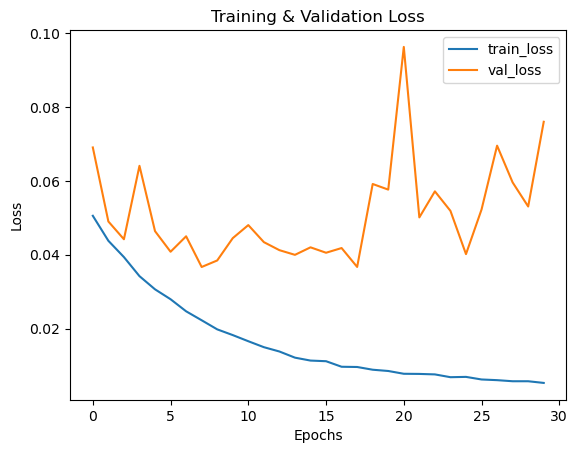

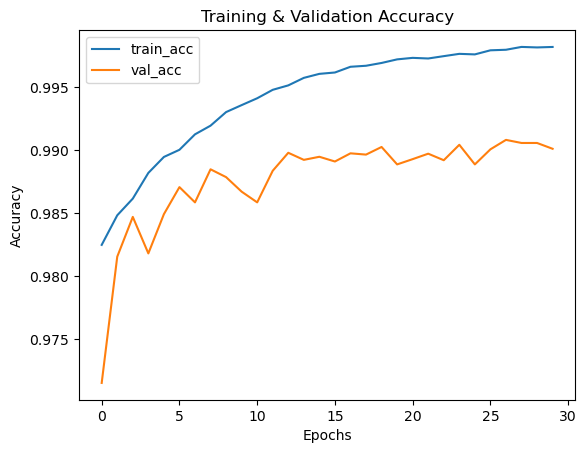

In [53]:
import matplotlib.pyplot as plt

# Loss
plt.figure()
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.show()

# Accuracy
plt.figure()
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.show()


## Test sur des données jamais vues

In [54]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

def prepare_data_from_dataset_dist(dataset):
    """
    Converts a Hugging Face-style dataset (with 'audio', 'label')
    into MFCC and GFCC feature tensors ready for training.

    dataset: Hugging Face Dataset (not streaming), each item should have:
        item["audio"]["array"] -> waveform as np.array
        item["audio"]["sampling_rate"] -> sampling rate
        item["label"] -> label (int or str)
    """
    mfcc_features_all = []
    gfcc_features_all = []
    labels = []
    size = len(dataset)

    for i, item in enumerate(dataset):
        # Ensure proper audio array
        audio = np.array(item["audio"]["array"], dtype=np.float32)
        if audio.size == 0:
            continue  # skip empty audio

        fs = item["audio"]["sampling_rate"]  # use actual sampling rate
        label = item["label"]
        labels.append(label)

        # Compute features
        mfcc_feat = mfcc(audio, samplerate=fs)
        gfcc_feat = gfcc(audio, fs=fs, num_ceps=13)

        # Align lengths
        min_len = min(mfcc_feat.shape[0], gfcc_feat.shape[0])
        mfcc_features_all.append(mfcc_feat[:min_len])
        gfcc_features_all.append(gfcc_feat[:min_len])

        if i % 100 == 0:  # smaller log frequency for smaller datasets
            print(f"Processed {(i/size)*100:.2f}% of samples...")

    print("Samples preprocessing finished.")
    
    # Determine maximum shapes
    def find_max_shape(features):
        h, l = 0, 0
        for f in features:
            a, b = np.array(f).shape
            h = max(h, a)
            l = max(l, b)
        return h, l

    def pad_to_shape(features, h, l):
        new_feats = []
        for f in features:
            a, b = np.array(f).shape
            padded = np.zeros((h, l), np.float32)
            padded[:a, :b] = f
            new_feats.append(padded)
        return np.array(new_feats, dtype=np.float32)

    h, l = find_max_shape(mfcc_features_all)
    h2, l2 = find_max_shape(gfcc_features_all)

    x_mfcc = pad_to_shape(mfcc_features_all, h, l)
    x_gfcc = pad_to_shape(gfcc_features_all, h2, l2)

    # Add channel dimension for Conv2D
    x_mfcc = np.expand_dims(x_mfcc, axis=-1)
    x_gfcc = np.expand_dims(x_gfcc, axis=-1)

    # Encode labels as integers
    encoder = LabelEncoder()
    y = encoder.fit_transform(labels).astype(np.int32)

    print("Preprocess finished.")
    print(f"x_mfcc: {x_mfcc.shape}, x_gfcc: {x_gfcc.shape}, y: {y.shape}")

    return x_mfcc, x_gfcc, y, h, l, h2, l2, encoder


In [55]:
ds_test_online = load_dataset("Usernameeeeee/drone_test", split="test")


In [56]:
ds_test_online2 = load_dataset("Usernameeeeee/drone_test_2", split="test")


In [59]:
foreign_data2 = prepare_data_from_dataset_dist(ds_test_online2)
foreign_data = prepare_data_from_dataset_dist(ds_test_online)


Processed 0.00% of samples...
Processed 3.57% of samples...
Processed 7.13% of samples...
Processed 10.70% of samples...
Processed 14.26% of samples...
Processed 17.83% of samples...
Processed 21.39% of samples...
Processed 24.96% of samples...
Processed 28.52% of samples...
Processed 32.09% of samples...
Processed 35.65% of samples...
Processed 39.22% of samples...
Processed 42.78% of samples...
Processed 46.35% of samples...
Processed 49.91% of samples...
Processed 53.48% of samples...
Processed 57.04% of samples...
Processed 60.61% of samples...
Processed 64.17% of samples...
Processed 67.74% of samples...
Processed 71.30% of samples...
Processed 74.87% of samples...
Processed 78.43% of samples...
Processed 82.00% of samples...
Processed 85.56% of samples...
Processed 89.13% of samples...
Processed 92.69% of samples...
Processed 96.26% of samples...
Processed 99.82% of samples...
Samples preprocessing finished.
Preprocess finished.
x_mfcc: (2805, 48, 13, 1), x_gfcc: (2805, 48, 13, 1

In [60]:
foreign_loss, foreign_acc = loaded_model.evaluate(
    [foreign_data[0], foreign_data[1]],
    foreign_data[2],
    batch_size=68,
    verbose=1
)

print(f"✅ Test accuracy: {foreign_acc:.4f}")
print(f"📉 Test loss: {foreign_loss:.4f}")


14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 396ms/step - accuracy: 0.5879 - loss: 2.0699
✅ Test accuracy: 0.5879
📉 Test loss: 2.0699


In [62]:
foreign2_loss, foreign2_acc = loaded_model.evaluate(
    [foreign_data2[0], foreign_data2[1]],
    foreign_data2[2],
    batch_size=68,
    verbose=1
)

print(f"✅ Test accuracy: {foreign2_acc:.4f}")
print(f"📉 Test loss: {foreign2_loss:.4f}")


42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.8217 - loss: 0.6462
✅ Test accuracy: 0.8217
📉 Test loss: 0.6462


In [63]:
import numpy as np

# Get predictions (probabilities)
y_pred_probs = loaded_model.predict([foreign_data[0], foreign_data[1]], batch_size=68, verbose=1)

# Convert probabilities → class indices
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = foreign_data[2]   # true labels (already integer-encoded)


14/14 ━━━━━━━━━━━━━━━━━━━━ 16s 651ms/step


In [65]:
import numpy as np

# Get predictions (probabilities)
y_pred_probs2 = loaded_model.predict([foreign_data2[0], foreign_data2[1]], batch_size=68, verbose=1)

# Convert probabilities → class indices
y_pred2 = np.argmax(y_pred_probs2, axis=1)
y_true2 = foreign_data2[2]   # true labels (already integer-encoded)


42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step


### Résultats des tests

#### drone_test

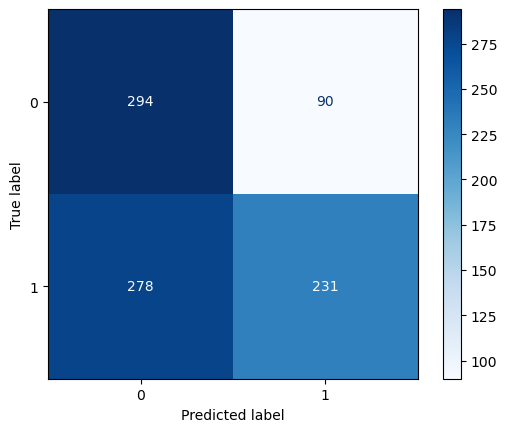

In [69]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')


In [70]:
import numpy as np

class_acc = cm.diagonal() / cm.sum(axis=1)
for i, acc in enumerate(class_acc):
    print(f"Class {i} accuracy: {acc:.2%}")


Class 0 accuracy: 76.56%
Class 1 accuracy: 45.38%


In [71]:
encoder = foreign_data2[-1]   # from your prepare_data_from_dataset_dist return
class_names = encoder.classes_

for name, acc in zip(class_names, class_acc):
    print(f"{name} → {acc:.2%} accuracy")


0 → 76.56% accuracy
1 → 45.38% accuracy


#### drone_test2

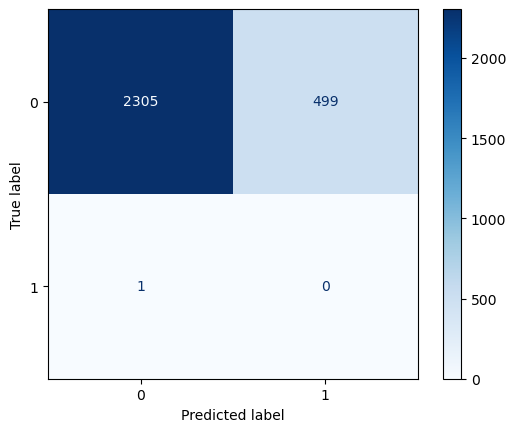

In [72]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true2, y_pred2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')


In [73]:
import numpy as np

class_acc = cm.diagonal() / cm.sum(axis=1)
for i, acc in enumerate(class_acc):
    print(f"Class {i} accuracy: {acc:.2%}")


Class 0 accuracy: 82.20%
Class 1 accuracy: 0.00%


In [74]:
encoder = foreign_data2[-1]   # from your prepare_data_from_dataset_dist return
class_names = encoder.classes_

for name, acc in zip(class_names, class_acc):
    print(f"{name} → {acc:.2%} accuracy")


0 → 82.20% accuracy
1 → 0.00% accuracy


### Labels des données jamais vues

In [75]:
print(ds_test_online.features["label"])


ClassLabel(names=['drone', 'other'])


In [76]:
print(ds_test_online2.features["label"])


ClassLabel(names=['drone', 'other'])
